## Dectando caracteres das placas com Paddle OCR

In [5]:
!pip install --no-cache-dir opencv-python-headless paddlepaddle==2.5.1 paddleocr==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 150.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.7/544.7 kB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 178.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 154.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.5/383.5 kB 151.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.8/297.8 kB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 138.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 123.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 139.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 131.9 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl s

In [ ]:
from paddleocr import PaddleOCR
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import numpy as np
import pandas as pd
import re
import os
from decimal import Decimal

In [ ]:
def show_image(img):
    cv2_imshow(img)

In [ ]:
# Função para aplicar OCR na região da placa
# Inicializar o PaddleOCR
ocr = PaddleOCR(lang='en')
def recorte_plate(plate_img_path):

    # Lê a imagem do disco
    plate_img = cv2.imread(plate_img_path)
    # Verifica se a imagem foi carregada corretamente
    if plate_img is None:
        print(f"Error: Could not read image from {plate_img_path}")
        return

    # Aumenta o tamanho da imagem
    img_size = cv2.resize(plate_img, None, fy=3, fx=3, interpolation=cv2.INTER_CUBIC)
    copia = img_size.copy()
    #show_image(img_size)

    # Converter a imagem para escala de cinza
    gray_plate = cv2.cvtColor(img_size, cv2.COLOR_BGR2GRAY)
    gray_plate = cv2.equalizeHist(gray_plate)

    # Operação morfológica de dilatação para preencher lacunas nas bordas
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    dilated_place = cv2.dilate(gray_plate, kernel, iterations=1)
    #show_image(dilated_place)

    cnts, _ = cv2.findContours(dilated_place, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    line_items_coordinates = []

    for c in cnts:
        area = cv2.contourArea(c)
        #print(area)
        x, y, w, h = cv2.boundingRect(c)
        if area > 10000:
            # Ajuste os valores de redução conforme necessário
            reduction_factor = 0.09

            new_w = int(w * (1.028 - reduction_factor))
            new_h = int(h * (0.83 - reduction_factor))

            # Calcular as novas coordenadas para manter a ROI centralizada
            new_x = x + (w - new_w) // 2
            new_y = y + (h - new_h) // 1

            # Certifique-se de que as novas coordenadas estejam dentro dos limites da imagem
            new_x = max(new_x, 0)
            new_y = max(new_y, 0)
            new_w = min(new_w, img_size.shape[1] - new_x)
            new_h = min(new_h, img_size.shape[0] - new_y)

            cv2.rectangle(copia, (new_x, new_y), (new_x + new_w, new_y + new_h), (255, 0, 255), 3)
            roi = img_size[new_y:new_y+new_h, new_x:new_x+new_w]  # Recorte a região de interesse (ROI) da imagem original
            show_image(roi)
            return roi
    return None

def detectar_placa(imagem_path):
    # Carregar a imagem
    textos_detectados = []
    imagem_rgb = cv2.cvtColor(imagem_path, cv2.COLOR_BGR2RGB)

    # Executar OCR na imagem
    resultados = ocr.ocr(imagem_rgb)

    for linha in resultados:
        print(f"linha: {linha}")
        if linha == None:
            textos_detectados.append(("texto nao detectado", "confianca nao detectada"))
            return textos_detectados
        else:
          for item in linha:
              box, (texto, * confidencia) = item
              conf = confidencia[0] if confidencia else None  # Confiança pode não estar presente
              texto_limpo = re.sub(r'[^a-zA-Z0-9]', '', texto)
              textos_detectados.append((texto_limpo, Decimal(str(conf))))

    print("Textos detectados com confiança:")
    for texto, conf in textos_detectados:
        if conf is not None:
            print(f"Texto: {texto} | Confiança: {conf:.2f}")
        else:
            print(f"Texto: {texto} | Confiança: Não disponível")

    return textos_detectados

# Função para processar imagens e salvar resultados
def processar_imagens(pasta_raiz, salvar_csv=False, caminho_csv="/content/drive/MyDrive/ColabNotebooks/tcc_mba/validacao_modelo_yolo_ocr/detectando_caracter_placa_ocr/planilha_comparacao/resultados_ocr.csv"):
    resultados_gerais = []
    for root, _, files in os.walk(pasta_raiz):
        for arquivo in files:
            if arquivo.endswith("placa.jpg"):
                caminho_imagem = os.path.join(root, arquivo)
                print(f"Processando: {caminho_imagem}")
                img_ocr = recorte_plate(caminho_imagem)
                if img_ocr is not None:
                    textos_detectados = detectar_placa(img_ocr)
                    for texto, confianca in textos_detectados:
                        resultados_gerais.append({
                            "Imagem": caminho_imagem,
                            "Texto": texto,
                            "Confiança": confianca
                        })

    # Criar DataFrame com os resultados
    df = pd.DataFrame(resultados_gerais)
    if salvar_csv:
        df.to_csv(caminho_csv, index=False, encoding="utf-8")
        print(f"Resultados salvos em: {caminho_csv}")

    return df

# Caminho para o diretório com as imagens
input_folder = '/content/drive/MyDrive/ColabNotebooks/tcc_mba/validacao_modelo_yolo_ocr/detectando_placa_yolo'

# Processar imagens e salvar os resultados em CSV
df_resultados = processar_imagens(input_folder, salvar_csv=True)

Output hidden; open in https://colab.research.google.com to view.

## Metricas de avaliação no reconhecimento dos caracteres

In [ ]:
def ler_placa(pasta_txt) -> str:
    try:
        with open(pasta_txt, 'r') as file:
            lines = file.readlines()
        car_plate = lines[1].strip().split(": ")[1]
        return car_plate
    except Exception as e:
        print(f"Erro ao processar o arquivo {pasta_txt}: {e}")
        return "Erro"

def calcular_acuracia(texto_reconhecido: str, placa_real: str) -> float:
    """
    Compara caractere por caractere entre o texto reconhecido e a placa real, retornando o percentual de acerto.
    """
    if texto_reconhecido.lower() == "texto nao detectado":
        return 0.0

    # Normaliza os textos para evitar problemas de case sensitivity
    texto_reconhecido = texto_reconhecido.strip().upper()
    placa_real = placa_real.strip().upper()

    # Usa regex para garantir que apenas caracteres alfanuméricos sejam comparados
    regex = re.compile(r"[A-Z0-9]")

    # Filtra apenas os caracteres válidos
    texto_filtrado = "".join([char for char in texto_reconhecido if regex.match(char)])
    placa_filtrada = "".join([char for char in placa_real if regex.match(char)])

    # Define o tamanho mínimo para comparação
    tamanho_comparacao = min(len(texto_filtrado), len(placa_filtrada))

    # Compara caractere por caractere
    acertos = sum(1 for i in range(tamanho_comparacao) if texto_filtrado[i] == placa_filtrada[i])

    # Calcula o percentual de acerto
    if tamanho_comparacao == 0:
        return 0.0  # Evita divisão por zero
    return (acertos / tamanho_comparacao) * 100

In [ ]:
df = (pd.read_csv('/content/drive/MyDrive/ColabNotebooks/tcc_mba/validacao_modelo_yolo_ocr/detectando_caracter_placa_ocr/planilha_comparacao/resultados_ocr.csv')
      .assign(PastaTxt=lambda df: df["Imagem"]
              .apply(lambda x: x.replace("detectando_placa_yolo", "placas/labels")
              .rsplit("/", 1)[0] + ".txt"))
      .assign(PlacaTxt=lambda df: df["PastaTxt"]
              .apply(ler_placa))
      .assign(Acuracia=lambda df: df.apply(lambda row: calcular_acuracia(row["Texto"], row["PlacaTxt"]), axis=1))
      .drop(columns=['Imagem','Texto','Confiança','PastaTxt']))
df.head()
df.size()

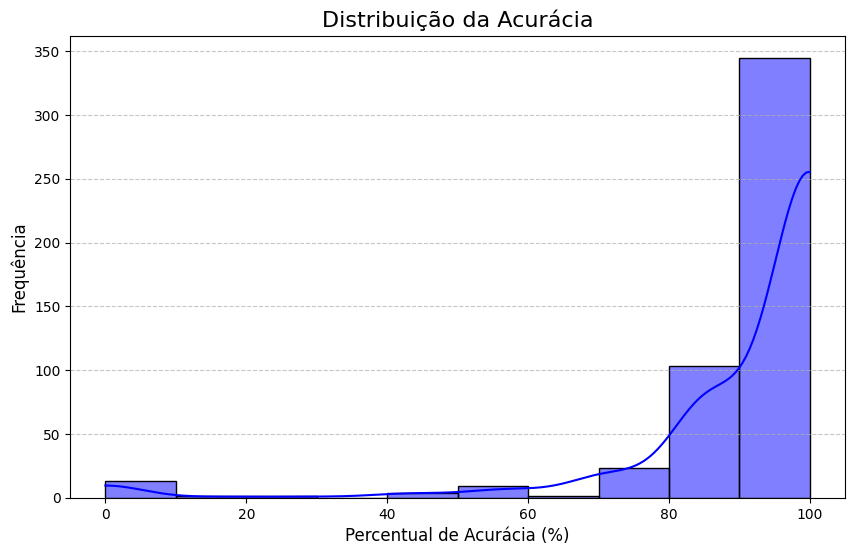

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotando o histograma da acurácia
plt.figure(figsize=(10, 6))
sns.histplot(df["Acuracia"], bins=10, kde=True, color="blue")
plt.title("Distribuição da Acurácia", fontsize=16)
plt.xlabel("Percentual de Acurácia (%)", fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

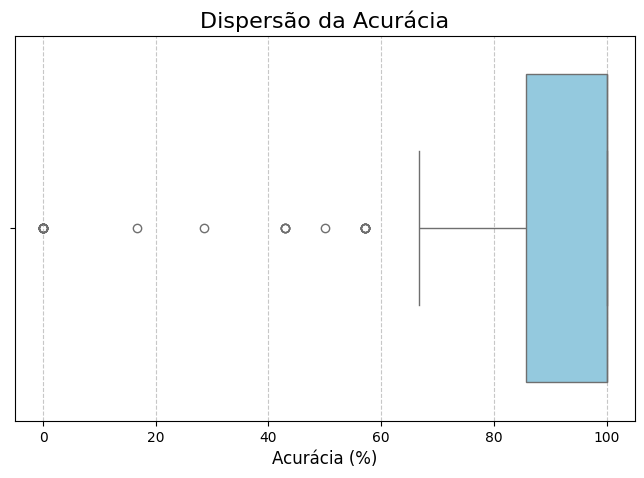

In [ ]:
# Boxplot da acurácia
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Acuracia", color="skyblue")
plt.title("Dispersão da Acurácia", fontsize=16)
plt.xlabel("Acurácia (%)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

<ipython-input-13-c87b377ed0f2>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=faixa_counts.index, y=faixa_counts.values, palette="viridis")


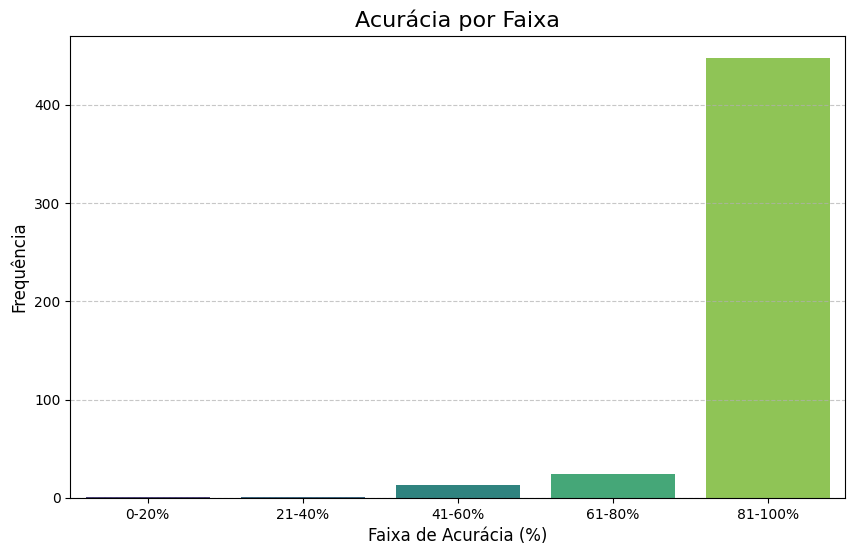

In [ ]:
# Criando faixas de acurácia
df["Faixa_Acuracia"] = pd.cut(
    df["Acuracia"],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["0-20%", "21-40%", "41-60%", "61-80%", "81-100%"]
)

# Contagem por faixa
faixa_counts = df["Faixa_Acuracia"].value_counts().sort_index()

# Plotando o barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=faixa_counts.index, y=faixa_counts.values, palette="viridis")
plt.title("Acurácia por Faixa", fontsize=16)
plt.xlabel("Faixa de Acurácia (%)", fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

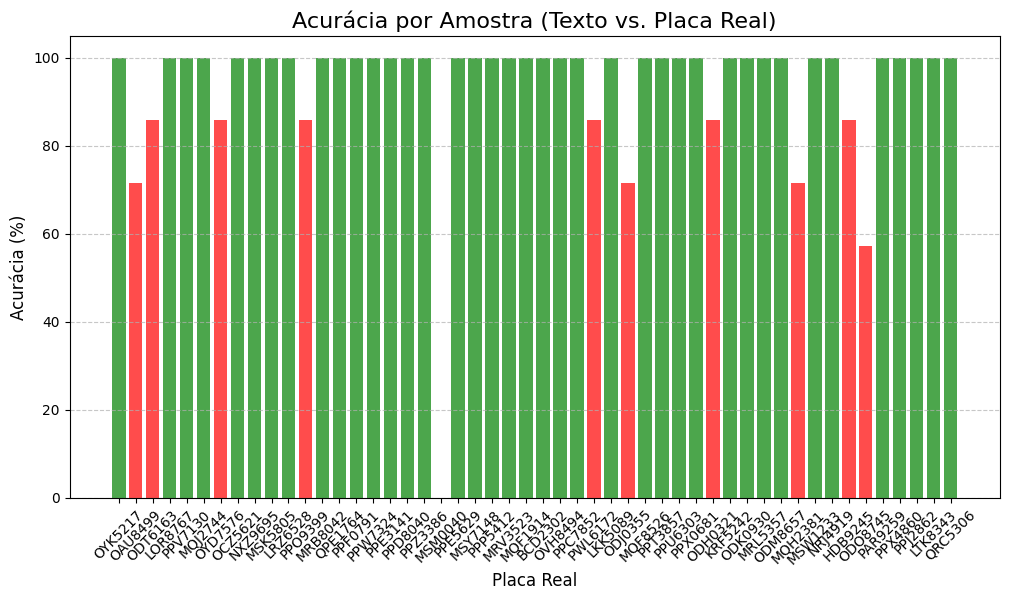

In [ ]:
# Selecionando as 50 primeiras amostras
amostras = df.head(50)

# Plotando o gráfico comparativo
plt.figure(figsize=(12, 6))
for i, row in amostras.iterrows():
    plt.bar(row["PlacaTxt"], row["Acuracia"], color="green" if row["Acuracia"] == 100 else "red", alpha=0.7)
plt.title("Acurácia por Amostra (Texto vs. Placa Real)", fontsize=16)
plt.xlabel("Placa Real", fontsize=12)
plt.ylabel("Acurácia (%)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

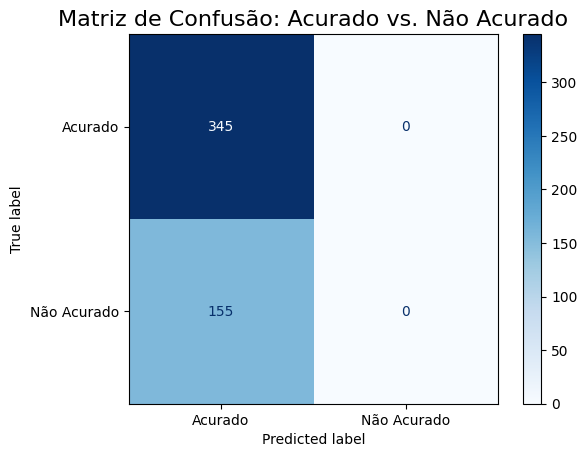

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Definindo limiar de acerto (exemplo: 100% de acurácia é considerado acerto completo)
df["Resultado"] = df["Acuracia"].apply(lambda x: "Acurado" if x == 100 else "Não Acurado")

# Criando matriz de confusão
matriz = confusion_matrix(df["Resultado"], ["Acurado"] * len(df["Resultado"]))

# Exibindo matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=["Acurado", "Não Acurado"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão: Acurado vs. Não Acurado", fontsize=16)
plt.show()

In [ ]:
# Resumo de métricas
metricas = {
    "Média da Acurácia (%)": df["Acuracia"].mean(),
    "Mediana da Acurácia (%)": df["Acuracia"].median(),
    "Desvio Padrão (%)": df["Acuracia"].std(),
    "Amostras Acuradas (100%)": len(df[df["Acuracia"] == 100]),
    "Total de Amostras": len(df)
}

# Exibindo como DataFrame para fácil visualização
metricas_df = pd.DataFrame(metricas, index=["Valores"])
print(metricas_df.T)

                             Valores
Média da Acurácia (%)      91.523810
Mediana da Acurácia (%)   100.000000
Desvio Padrão (%)          18.848926
Amostras Acuradas (100%)  345.000000
Total de Amostras         500.000000


No contexto geral o Paddle OCR tem uma taxa de acertividade boa, lembrando que
realizamos uma comparação de caracter por caracter para saber a taxa.